In [35]:
from transformers import AutoProcessor, AutoModelForTokenClassification
import torch
import os
from pathlib import Path
ROOT_DIR = Path(os.getcwd()).parent
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
from datasets import load_dataset 

# this dataset uses the new Image feature :)
dataset = load_dataset("./dataset_loader.py")

In [56]:

labels = ['page_number', 'building_material', 'settlement_classification', 'parish', 'building_type', 'dedication', 'deanery']
bio_labels = ["B-{}".format(label) for label in labels] + ["I-{}".format(label) for label in labels] + ["O"]

label2id = {label: i for i, label in enumerate(bio_labels)}
id2label = {i: label for i, label in enumerate(bio_labels)}


num_labels = len(id2label)

model = AutoModelForTokenClassification.from_pretrained(os.path.join(ROOT_DIR, "models/layoutlmv3/checkpoint-400"), num_labels=num_labels, id2label=id2label, label2id=label2id)

processor = AutoProcessor.from_pretrained(
    "microsoft/layoutlmv3-large",
    apply_ocr=True
)

In [37]:
from PIL import Image

image = Image.open("/Users/user/Projects/ecclesiasticalOCR/data/schematyzmy/lublin_1871/0005.jpg").convert("RGB")      # twoja funkcja / pytesseract

inputs = processor(image, return_tensors="pt", truncation=True, max_length=512)
with torch.no_grad():
    logits = model(**inputs).logits

pred_ids   = logits.argmax(-1).squeeze().tolist()
pred_labels= [model.config.id2label[i] for i in pred_ids]
print(set(pred_labels))

/opt/anaconda3/envs/ocr/lib/python3.12/site-packages/transformers/modeling_utils.py:1558: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'B-dedication', 'I-deanery', 'O'}


In [38]:
def unnormalize_bbox(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]


In [39]:
import numpy as np
import random

def sliding_window(processor, token_boxes, predictions, encoding, width, height):
    box_token_dict = {}
    for i in range(len(token_boxes)):
        initial_j = 0 if i == 0 else 128
        for j in range(initial_j, len(token_boxes[i])):
            tb = token_boxes[i][j]
            # skip bad boxes
            if not hasattr(tb, "__len__") or len(tb) != 4 or tb == [0, 0, 0, 0]:
                continue
            # normalize once here
            unnorm = unnormalize_bbox(tb, width, height)
            key = tuple(round(x, 2) for x in unnorm)  # use a consistent key
            tok = processor.tokenizer.decode(encoding["input_ids"][i][j]).strip()
            box_token_dict.setdefault(key, []).append(tok)

    # build predictions dict with the *same* keys
    box_prediction_dict = {}
    for i in range(len(token_boxes)):
        for j in range(len(token_boxes[i])):
            tb = token_boxes[i][j]
            if not hasattr(tb, "__len__") or len(tb) != 4 or tb == [0, 0, 0, 0]:
                continue
            unnorm = unnormalize_bbox(tb, width, height)
            key = tuple(round(x, 2) for x in unnorm)
            box_prediction_dict.setdefault(key, []).append(predictions[i][j])

    # now your majority‐vote on box_pred_dict → preds
    boxes = list(box_token_dict.keys())
    words = ["".join(ws) for ws in box_token_dict.values()]
    preds = []
    for key, preds_list in box_prediction_dict.items():
        # Simple majority voting - get the most common prediction
        final = max(set(preds_list), key=preds_list.count)
        preds.append(final)

    return boxes, preds, words


In [ ]:
from PIL import Image, ImageDraw, ImageFont

def visualize_entity_boxes(image_path, boxes, preds, words, id2label, output_path=None):
    """
    Visualize detected entities on an image.
    
    Args:
        image_path (str): Path to the image file
        boxes (list): List of bounding boxes as tuples/lists (x1, y1, x2, y2)
        preds (list): List of prediction IDs (integers)
        words (list): List of word text for each box
        id2label (dict): Dictionary mapping prediction IDs to label strings
        output_path (str, optional): If provided, save visualization to this path
    
    Returns:
        PIL.Image: Annotated image
    """
    from PIL import Image, ImageDraw, ImageFont
    import os
    
    # Load image
    image = Image.open(image_path).convert("RGB")
    image_draw = image.copy()
    draw = ImageDraw.Draw(image_draw)
    
    # Try to load a nicer font, fall back to default if not available
    try:
        font = ImageFont.truetype("Arial", 12)
    except IOError:
        font = ImageFont.load_default()
    
    # Color mapping for different entity types
    label2color = {
        'B-building_material': 'red',
        'I-building_material': 'red',
        'I-building_type': 'blue',
        'I-deanery': 'green',
        'I-dedication': 'orange',
        'I-page_number': 'purple',
        'I-parish': 'brown',
        'I-settlement_classification': 'cyan',
        'B-building_material': 'red',
        'B-building_type': 'blue',
        'B-deanery': 'green',
        'B-dedication': 'orange',
        'B-page_number': 'purple',
        'B-parish': 'brown',
        'B-settlement_classification': 'cyan',
        'O': 'gray'  # "Outside" entity
    }
    
    # Draw each entity with its label
    for i, (box, pred, word) in enumerate(zip(boxes, preds, words)):
        # Get label from prediction ID
        label = id2label.get(pred, "O")
        
        # Skip "O" (Outside) labels to focus only on named entities
        if label == "O":
            continue
            
        print(f"Drawing box for word: {word}, label: {label}, box: {box}")
        # Extract entity type from BIO tag (e.g., "B-parish" -> "parish")
        if label.startswith("B-") or label.startswith("I-"):
            entity_type = label
        else:
            entity_type = label
            
        # Get color for this entity type
        color = label2color.get(entity_type, 'yellow')  # Default to yellow if unknown
        
        # Draw bounding box
        draw.rectangle(box, outline=color, width=2)
        
        # Create label text with entity type and word
        label_text = f"{entity_type}: {word}"
        
        # Calculate text position (above the box)
        text_y = max(0, box[1] - 15)
        
        # Add background for text
        text_width = draw.textlength(label_text, font=font)
        # draw.rectangle(
        #     [box[0], text_y, box[0] + text_width, text_y + 15],
        #     fill=(255, 255, 255, 180)  # Semi-transparent white background
        # )
        draw.rectangle(box, outline=color, width=3)

        
        # Draw text
        draw.text(
            (box[0], text_y),
            label_text,
            fill=color,
            font=font
        )
    
    # Save if output path provided
    if output_path:
        image_draw.save(output_path)
    
    return image_draw

/var/folders/lw/767gd31d7d3ctzj1jms858l80000gn/T/ipykernel_25633/2471425394.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoding[k] = torch.tensor(v)
/opt/anaconda3/envs/ocr/lib/python3.12/site-packages/transformers/modeling_utils.py:1558: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


torch.Size([2, 512, 15])
Drawing box for word: 71, label: B-page_number, box: (566.95, 77.9, 600.3, 102.6)
Drawing box for word: 4,, label: B-parish, box: (93.15, 486.4, 118.45, 509.2)
Drawing box for word: Bogdanow,, label: I-parish, box: (142.6, 476.9, 313.95, 516.8)
Drawing box for word: p., label: B-settlement_classification, box: (331.2, 486.4, 359.95, 514.9)
Drawing box for word: TE., label: B-building_type, box: (381.8, 476.9, 440.45, 503.5)
Drawing box for word: SS., label: B-dedication, box: (464.6, 476.9, 518.65, 503.5)
Drawing box for word: 7rinit., label: I-dedication, box: (545.1, 476.9, 647.45, 503.5)
Drawing box for word: mur., label: B-building_material, box: (671.6, 486.4, 742.9, 503.5)
Drawing box for word: 5., label: B-parish, box: (92.0, 1124.8, 117.3, 1151.4)
Drawing box for word: Chabielice,, label: I-parish, box: (142.6, 1122.9, 315.1, 1160.9)
Drawing box for word: p., label: B-settlement_classification, box: (338.1, 1132.4, 365.7, 1157.1)
Drawing box for word: T

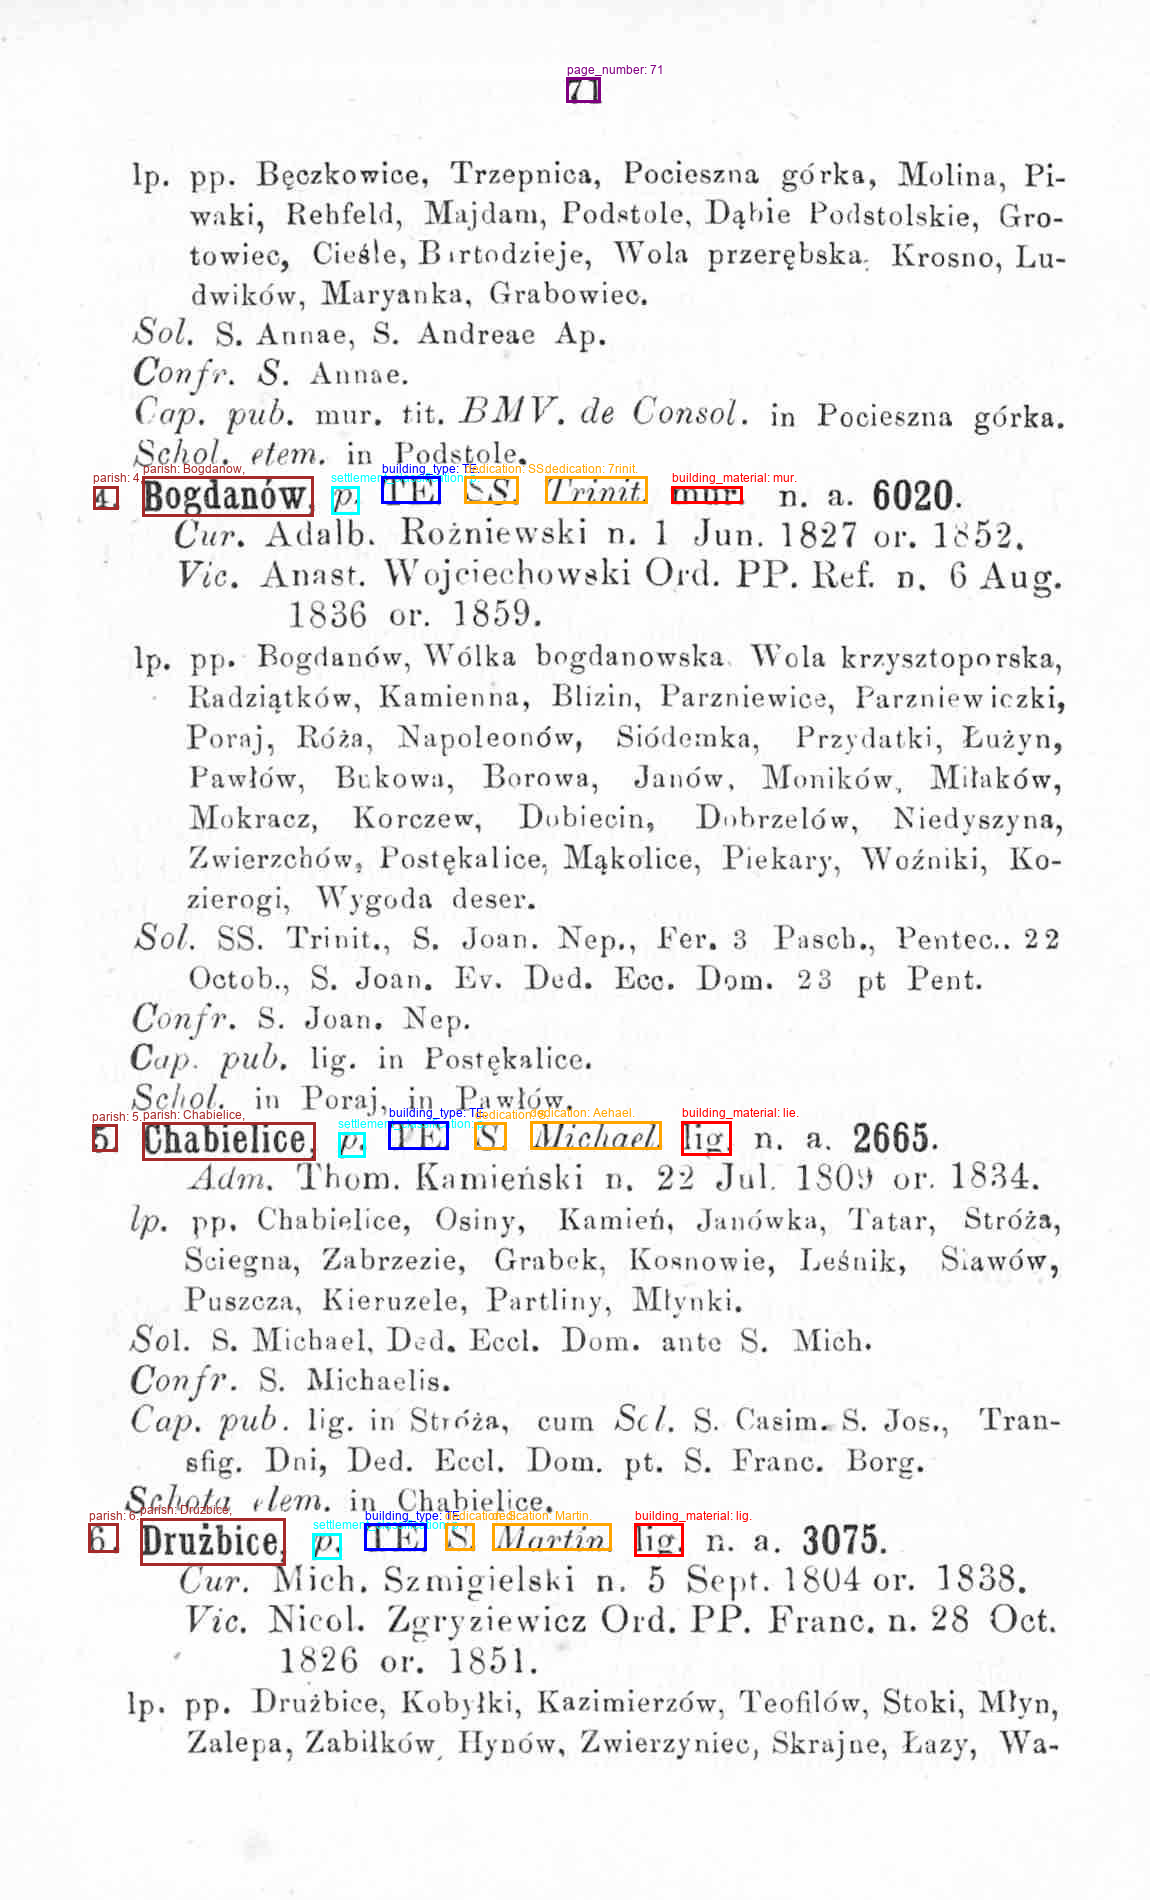

In [ ]:
# change the shape of pixel values


import random
schematism_dir = "data/schematyzmy/wloclawek_1872"
for image_file_name in os.listdir(os.path.join(ROOT_DIR, schematism_dir)):
    if not image_file_name.endswith(".jpg"):
        continue
    image_path = os.path.join(ROOT_DIR, schematism_dir, image_file_name)


torch.Size([2, 512, 15])
Drawing box for word: 10, label: B-page_number, box: (554.3, 108.3, 588.8, 134.9)
Drawing box for word: Decanatus, label: I-deanery, box: (297.85, 522.5, 532.45, 573.8)
Drawing box for word: Vladislaviensis,, label: I-deanery, box: (566.95, 522.5, 918.85, 583.3)
Drawing box for word: 1., label: B-parish, box: (95.45, 687.8, 120.75, 712.5)
Drawing box for word: Wioclawek,, label: I-parish, box: (143.75, 685.9, 330.05, 723.9)
Drawing box for word: civ., label: B-settlement_classification, box: (359.95, 687.8, 408.25, 714.4)
Drawing box for word: 1, label: B-building_type, box: (432.4, 687.8, 443.9, 714.4)
Drawing box for word: cl., label: I-building_type, box: (462.3, 687.8, 497.95, 714.4)
Drawing box for word: Titul., label: I-building_type, box: (514.05, 687.8, 602.6, 714.4)
Drawing box for word: Eccl., label: I-building_type, box: (625.6, 687.8, 706.1, 716.3)
Drawing box for word: S., label: I-dedication, box: (730.25, 687.8, 759.0, 716.3)
Drawing box for word

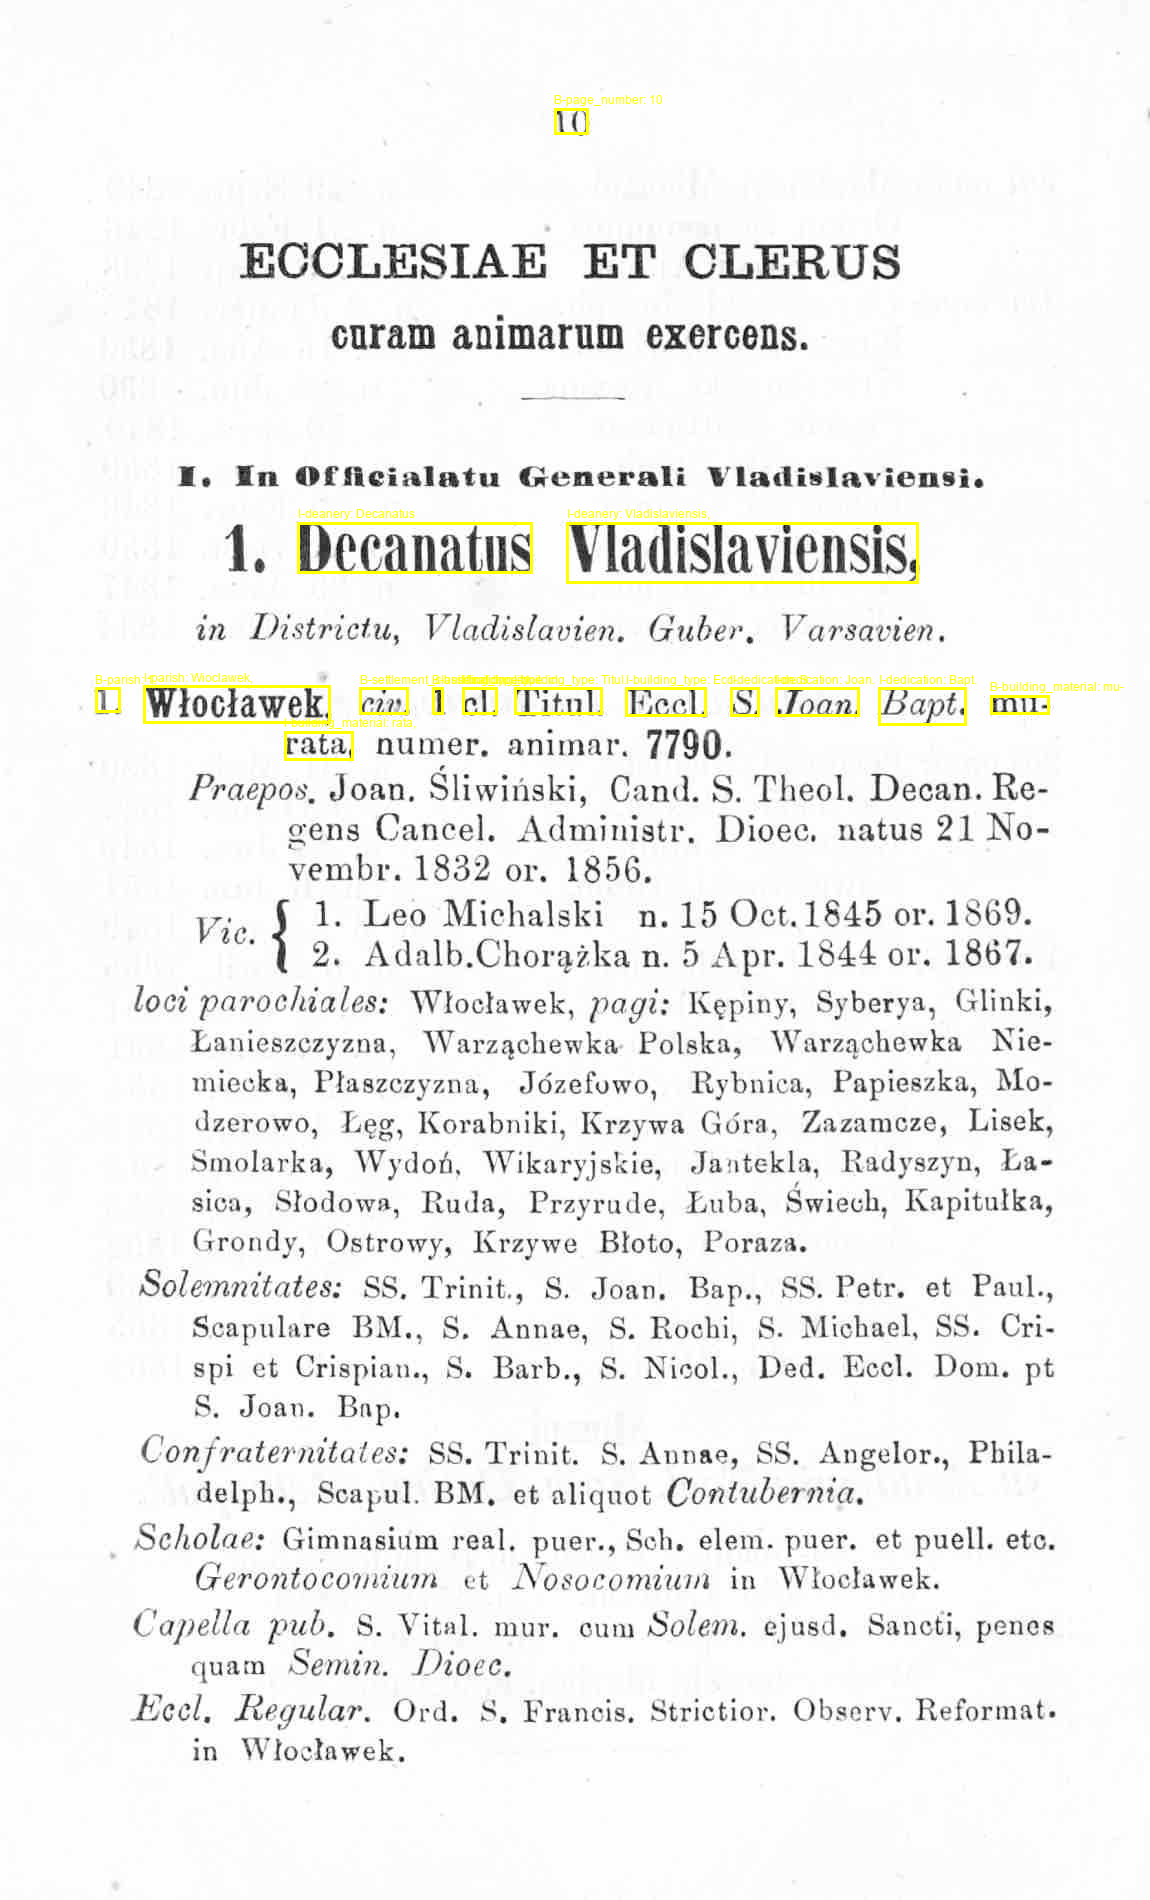

Starting new entity: page_number, token: 10
Finalized entity (due to O): page_number -> '10'
Starting new entity (from invalid I-): deanery, token: Decanatus
Continuing entity: deanery, token: Vladislaviensis,
Finalized entity (due to O): deanery -> 'Decanatus Vladislaviensis,'
Starting new entity: parish, token: 1.
Continuing entity: parish, token: Wioclawek,
Finalized entity (due to B-): parish -> '1. Wioclawek,'
Starting new entity: settlement_classification, token: civ.
Finalized entity (due to B-): settlement_classification -> 'civ.'
Starting new entity: building_type, token: 1
Continuing entity: building_type, token: cl.
Continuing entity: building_type, token: Titul.
Continuing entity: building_type, token: Eccl.
Finalized entity (due to invalid I-): building_type -> '1 cl. Titul. Eccl.'
Starting new entity (from invalid I-): dedication, token: S.
Continuing entity: dedication, token: Joan.
Continuing entity: dedication, token: Bapt.
Finalized entity (due to B-): dedication -> '

In [77]:
image_path = "/Users/user/Projects/AI_Osrodek/data/schematyzmy/wloclawek_1872/0010.jpg"
image = Image.open(image_path).convert("RGB")
image_width, image_height = image.size
encoding = processor(image, truncation=True, stride =128, 
        padding="max_length", max_length=512, return_overflowing_tokens=True, return_offsets_mapping=True)

offset_mapping = encoding.pop('offset_mapping')

overflow_to_sample_mapping = encoding.pop('overflow_to_sample_mapping')

x = []
for i in range(0, len(encoding['pixel_values'])):
    ndarray_pixel_values = encoding['pixel_values'][i]
    # Convert to tensor
    tensor_pixel_values = torch.tensor(ndarray_pixel_values)
    # Reshape to (3, 224, 224)
    #tensor_pixel_values = tensor_pixel_values.reshape(3, 224, 224)
    x.append(tensor_pixel_values)
    # Reshape to (3, 224, 224)

x = torch.stack(x)

encoding['pixel_values'] = x

for k, v in encoding.items():
    encoding[k] = torch.tensor(v)

with torch.no_grad():
    outputs = model(**encoding)

# The model outputs logits of shape (batch_size, seq_len, num_labels).
logits = outputs.logits
print(logits.shape)

# We take the highest score for each token, using argmax. This serves as the predicted label for each token.
predictions = logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

if (len(token_boxes) == 512):
    predictions = [predictions]
    token_boxes = [token_boxes]

boxes, preds, flattened_words = sliding_window(processor, token_boxes, predictions, encoding, image_width, image_height)
sample = [boxes, preds, flattened_words]
result_image = visualize_entity_boxes(
    image_path,
    boxes,
    preds,
    flattened_words,
    id2label,
    output_path="visualization_output.jpg"  # Optional
)

# Display in notebook
from IPython.display import display
display(result_image)


merged_boxes, merged_tokens, merged_classes = merge_bio_entities(
    boxes,
    preds,
    flattened_words,
    id2label,
    o_label_id=14,
    verbose=True
)

In [69]:
# In cell with id '8b3bf81e'

# ... existing imports ...

def merge_bio_entities(bboxes, predictions, tokens, id2label, o_label_id=14, verbose=False):
    """
    Merge consecutive BIO entities into single bounding boxes and tokens.

    Args:
        bboxes (list): List of bounding boxes [x1, y1, x2, y2].
        predictions (list): List of predicted label IDs.
        tokens (list): List of tokens/words.
        id2label (dict): Mapping from label ID to label string (e.g., {0: 'B-parish', ...}).
        o_label_id (int): The label ID for 'O' (outside) class.
        verbose (bool): If True, print debug info.

    Returns:
        merged_boxes (list): List of merged bounding boxes.
        merged_tokens (list): List of merged entity strings.
        merged_classes (list): List of merged entity class names (e.g., 'parish').
    """
    # Validate inputs
    if not (len(bboxes) == len(predictions) == len(tokens)):
        raise ValueError("bboxes, predictions, and tokens must have the same length")
    # Check if all non-'O' predictions are valid keys in id2label
    invalid_preds = [pred for pred in predictions if pred != o_label_id and pred not in id2label]
    if invalid_preds:
        # Optionally raise an error or just print a warning
        print(f"Warning: Invalid prediction IDs found and will be treated as 'O': {invalid_preds}")
        # raise ValueError(f"Invalid prediction IDs found: {invalid_preds}")

    merged_boxes = []
    merged_tokens = []
    merged_classes = []

    bbox_stack = []
    token_stack = []
    current_entity_type = None  # e.g., 'parish'

    def get_entity_type(label_id):
        """Extract entity type from BIO label ID (e.g., 'B-parish' -> 'parish')."""
        if label_id == o_label_id or label_id not in id2label:
             return None
        label = id2label[label_id]
        return label[2:] if label.startswith(('B-', 'I-')) else None

    def merge_entity(stack_bboxes, stack_tokens, entity_type):
        """Merge stacked boxes and tokens into a single entity."""
        if not stack_bboxes or not stack_tokens or not entity_type:
            return None, None, None
        # Ensure all bboxes in stack are valid lists/tuples of 4 numbers
        valid_bboxes = [b for b in stack_bboxes if isinstance(b, (list, tuple)) and len(b) == 4 and all(isinstance(coord, (int, float)) for coord in b)]
        if not valid_bboxes:
             if verbose: print(f"Warning: No valid bboxes found in stack for entity {entity_type}")
             return None, None, None
        try:
            merged_bbox = [
                min(bbox[0] for bbox in valid_bboxes),
                min(bbox[1] for bbox in valid_bboxes),
                max(bbox[2] for bbox in valid_bboxes),
                max(bbox[3] for bbox in valid_bboxes),
            ]
            merged_token = " ".join(map(str, stack_tokens)) # Ensure tokens are strings
            return merged_bbox, merged_token, entity_type
        except Exception as e:
            if verbose: print(f"Error merging entity {entity_type}: {e}")
            return None, None, None


    for i, (bbox, prediction, token) in enumerate(zip(bboxes, predictions, tokens)):
        # Skip potentially invalid bounding boxes early
        if not isinstance(bbox, (list, tuple)) or len(bbox) != 4:
             if verbose:
                 print(f"Skipping invalid bbox format at index {i}: {bbox}")
             # If skipping invalidates an ongoing entity, finalize the previous one
             if bbox_stack:
                 merged_bbox, merged_token, entity_class = merge_entity(
                     bbox_stack, token_stack, current_entity_type
                 )
                 if merged_bbox:
                     merged_boxes.append(merged_bbox)
                     merged_tokens.append(merged_token)
                     merged_classes.append(entity_class)
                     if verbose: print(f"Finalized entity (due to invalid bbox): {entity_class} -> '{merged_token}'")
                 bbox_stack = []
                 token_stack = []
                 current_entity_type = None
             continue


        label = id2label.get(prediction)
        # Handle invalid prediction ID if validation didn't catch it or wasn't strict
        if label is None:
             if verbose:
                 print(f"Warning: Invalid prediction ID {prediction} at index {i}. Treating as O.")
             prediction = o_label_id # Treat as O
             label = "O"

        new_entity_type = get_entity_type(prediction)

        # Case 1: Current token is O
        if prediction == o_label_id:
            if bbox_stack: # Finalize the previous entity
                merged_bbox, merged_token, entity_class = merge_entity(
                    bbox_stack, token_stack, current_entity_type
                )
                if merged_bbox:
                    merged_boxes.append(merged_bbox)
                    merged_tokens.append(merged_token)
                    merged_classes.append(entity_class)
                    if verbose: print(f"Finalized entity (due to O): {entity_class} -> '{merged_token}'")
                bbox_stack = []
                token_stack = []
                current_entity_type = None
            # Do nothing else for O

        # Case 2: Current token is B-
        elif label.startswith('B-'):
            if bbox_stack: # Finalize the previous entity first
                merged_bbox, merged_token, entity_class = merge_entity(
                    bbox_stack, token_stack, current_entity_type
                )
                if merged_bbox:
                    merged_boxes.append(merged_bbox)
                    merged_tokens.append(merged_token)
                    merged_classes.append(entity_class)
                    if verbose: print(f"Finalized entity (due to B-): {entity_class} -> '{merged_token}'")

            # Start new entity
            bbox_stack = [bbox]
            token_stack = [str(token)] # Ensure token is string
            current_entity_type = new_entity_type
            if verbose:
                print(f"Starting new entity: {current_entity_type}, token: {token}")

        # Case 3: Current token is I-
        elif label.startswith('I-'):
            # Ensure new_entity_type is valid before proceeding
            if new_entity_type is None:
                 if verbose: print(f"Warning: I- tag {label} for token {token} has no valid entity type. Treating as O.")
                 # Finalize previous entity if any
                 if bbox_stack:
                     merged_bbox, merged_token, entity_class = merge_entity(bbox_stack, token_stack, current_entity_type)
                     if merged_bbox:
                         merged_boxes.append(merged_bbox)
                         merged_tokens.append(merged_token)
                         merged_classes.append(entity_class)
                         if verbose: print(f"Finalized entity (due to invalid I- type): {entity_class} -> '{merged_token}'")
                     bbox_stack = []
                     token_stack = []
                     current_entity_type = None
                 continue # Skip to next token


            if bbox_stack and current_entity_type == new_entity_type:
                # Continue the current entity
                bbox_stack.append(bbox)
                token_stack.append(str(token)) # Ensure token is string
                if verbose:
                    print(f"Continuing entity: {current_entity_type}, token: {token}")
            else:
                # Invalid I-: Mismatched type or I- follows O/Start. Treat as B-.
                if verbose:
                    reason = "follows O/Start/Invalid" if not bbox_stack else f"mismatched type (expected {current_entity_type}, got {new_entity_type})"
                    print(f"Warning: Invalid I- tag {label} for token {token} ({reason}). Treating as B-{new_entity_type}.")

                if bbox_stack: # Finalize the previous entity if it exists
                    merged_bbox, merged_token, entity_class = merge_entity(
                        bbox_stack, token_stack, current_entity_type
                    )
                    if merged_bbox:
                        merged_boxes.append(merged_bbox)
                        merged_tokens.append(merged_token)
                        merged_classes.append(entity_class)
                        if verbose: print(f"Finalized entity (due to invalid I-): {entity_class} -> '{merged_token}'")

                # Start new entity based on this "invalid" I- tag's type
                bbox_stack = [bbox]
                token_stack = [str(token)] # Ensure token is string
                current_entity_type = new_entity_type
                if verbose:
                    print(f"Starting new entity (from invalid I-): {current_entity_type}, token: {token}")

    # Final check: Merge any remaining entity after the loop
    if bbox_stack:
        merged_bbox, merged_token, entity_class = merge_entity(
            bbox_stack, token_stack, current_entity_type
        )
        if merged_bbox:
            merged_boxes.append(merged_bbox)
            merged_tokens.append(merged_token)
            merged_classes.append(entity_class)
            if verbose: print(f"Finalized entity (end of list): {entity_class} -> '{merged_token}'")

    # Final validation for visualization function compatibility
    if not (len(merged_boxes) == len(merged_tokens) == len(merged_classes)):
         print("Error: Length mismatch after merging! Check verbose logs.")
         print(f"Boxes: {len(merged_boxes)}, Tokens: {len(merged_tokens)}, Classes: {len(merged_classes)}")
         # Depending on severity, you might want to return empty lists or raise an error
         # return [], [], []


    return merged_boxes, merged_tokens, merged_classes

# ... rest of the cell ...

In [67]:
for b, m, c in zip(boxes, preds, flattened_words):
    print(b, m, c)

(554.3, 108.3, 588.8, 134.9) 0 10
(239.2, 241.3, 545.1, 277.4) 14 ECCLESIAE
(583.05, 241.3, 655.5, 277.4) 14 ET
(684.25, 243.2, 899.3, 279.3) 14 CLERUS
(331.2, 323.0, 434.7, 349.6) 14 curam
(451.95, 313.5, 623.3, 349.6) 14 animarum
(646.3, 323.0, 807.3, 349.6) 14 exercens.
(178.25, 465.5, 209.3, 486.4) 14 I.
(235.75, 463.6, 278.3, 486.4) 14 En
(295.55, 465.5, 497.95, 486.4) 14 Officialatu
(518.65, 465.5, 684.25, 486.4) 14 Generali
(707.25, 465.5, 982.1, 486.4) 14 Vladislaviensi.
(224.25, 522.5, 264.5, 571.9) 14 1.
(297.85, 522.5, 532.45, 573.8) 13 Decanatus
(566.95, 522.5, 918.85, 583.3) 13 Vladislaviensis,
(196.65, 613.7, 224.25, 638.4) 14 in
(249.55, 611.8, 397.9, 644.1) 14 Liistrictu,
(426.65, 611.8, 623.3, 640.3) 14 Vladislavien.
(649.75, 613.7, 752.1, 642.2) 14 Guber.
(782.0, 613.7, 943.0, 640.3) 14 Varsavien.
(95.45, 687.8, 120.75, 712.5) 3 1.
(143.75, 685.9, 330.05, 723.9) 10 Wioclawek,
(359.95, 687.8, 408.25, 714.4) 2 civ.
(432.4, 687.8, 443.9, 714.4) 4 1
(462.3, 687.8, 497.95,

Starting new entity: page_number, token: 10
Finalized entity (due to O): page_number -> '10'
Starting new entity (from invalid I-): deanery, token: Decanatus
Continuing entity: deanery, token: Vladislaviensis,
Finalized entity (due to O): deanery -> 'Decanatus Vladislaviensis,'
Starting new entity: parish, token: 1.
Continuing entity: parish, token: Wioclawek,
Finalized entity (due to B-): parish -> '1. Wioclawek,'
Starting new entity: settlement_classification, token: civ.
Finalized entity (due to B-): settlement_classification -> 'civ.'
Starting new entity: building_type, token: 1
Continuing entity: building_type, token: cl.
Continuing entity: building_type, token: Titul.
Continuing entity: building_type, token: Eccl.
Finalized entity (due to invalid I-): building_type -> '1 cl. Titul. Eccl.'
Starting new entity (from invalid I-): dedication, token: S.
Continuing entity: dedication, token: Joan.
Continuing entity: dedication, token: Bapt.
Finalized entity (due to B-): dedication -> '

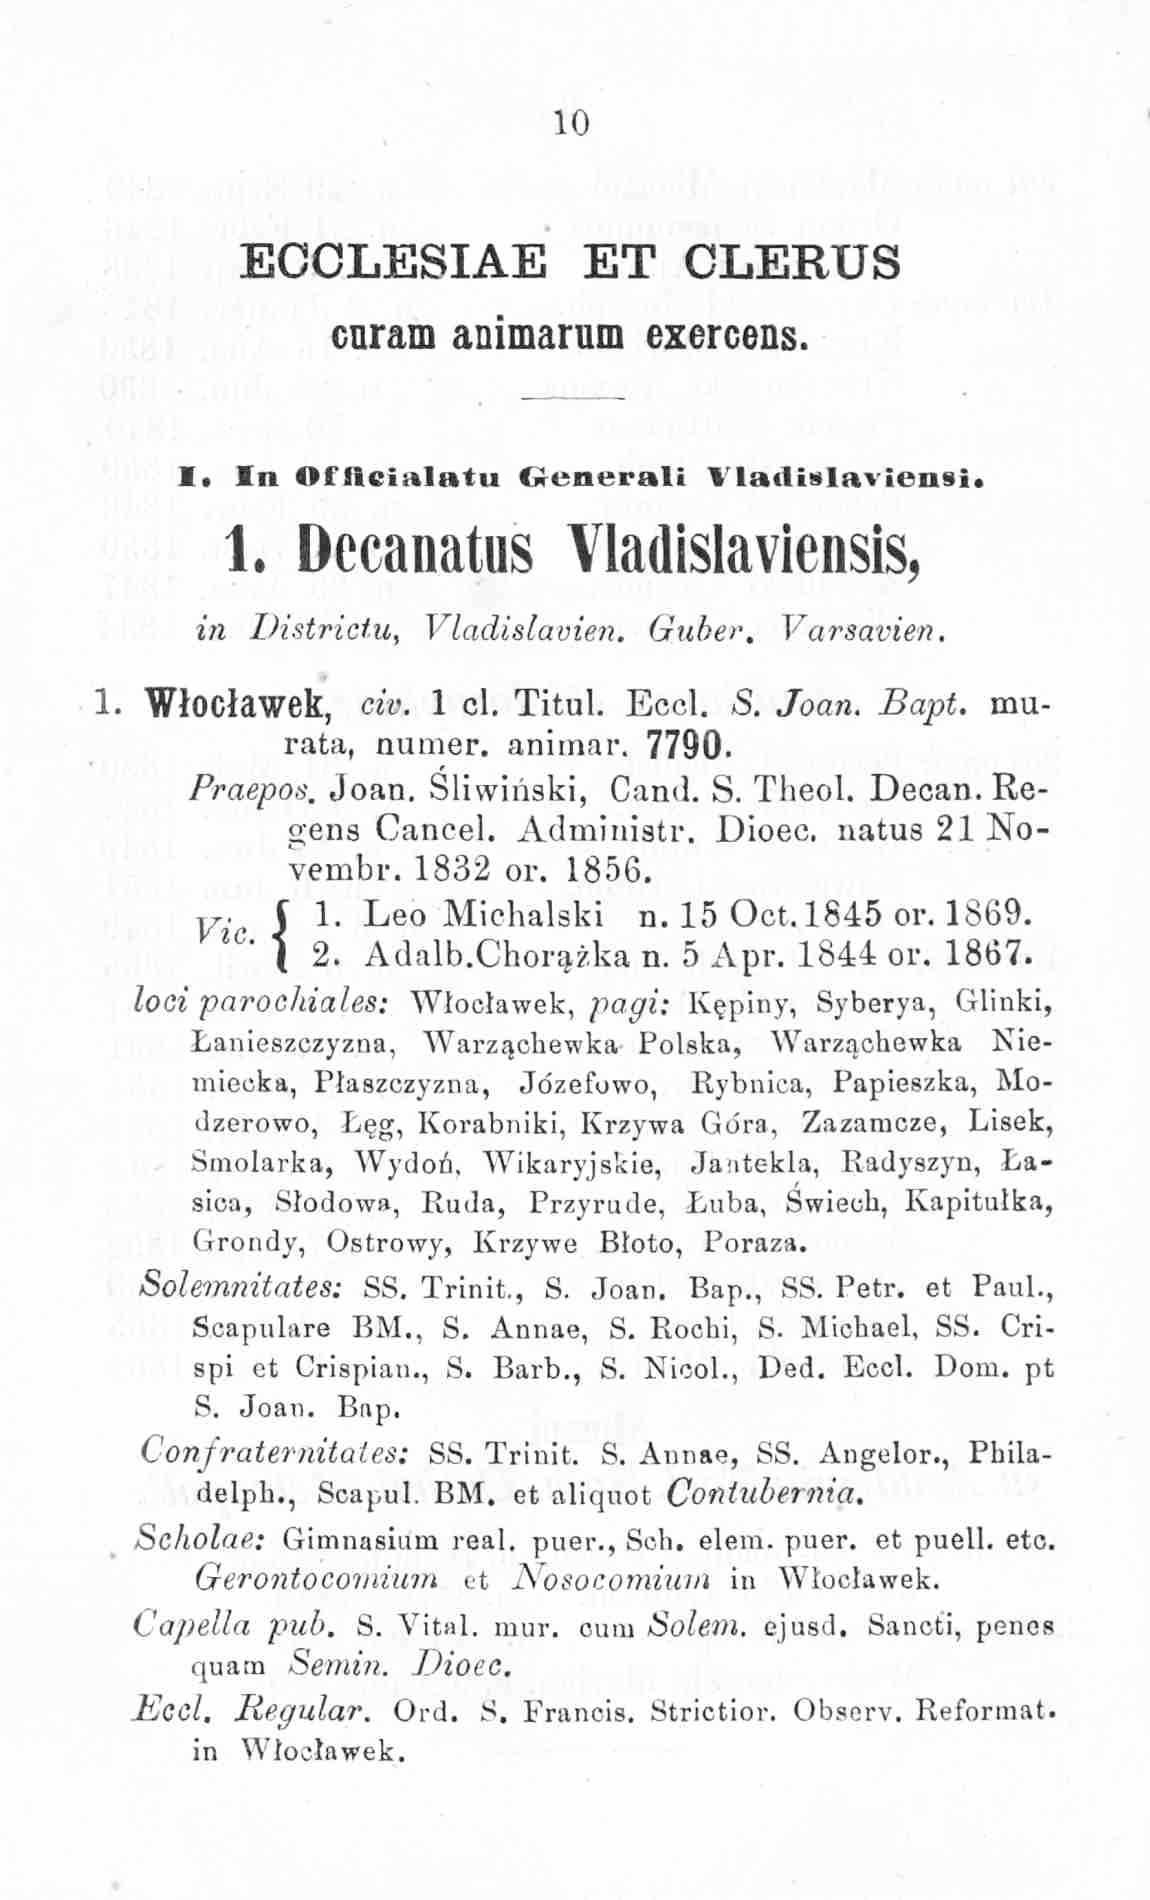

In [ ]:

merged_boxes, merged_tokens, merged_classes = merge_bio_entities(
    boxes,
    preds,
    flattened_words,
    id2label,
    o_label_id=14,
    verbose=True
)

result_image = visualize_entity_boxes(
    image_path,
    preds,
    merged_classes,
    flattened_words,
    id2label,
    output_path="visualization_output.jpg"  # Optional
)

# Display in notebook
from IPython.display import display
display(result_image)


In [74]:
merged_boxes, merged_tokens, merged_classes

([[554.3, 108.3, 588.8, 134.9],
  [297.85, 522.5, 918.85, 583.3],
  [95.45, 685.9, 330.05, 723.9],
  [359.95, 687.8, 408.25, 714.4],
  [432.4, 687.8, 706.1, 716.3],
  [730.25, 687.8, 966.0, 725.8],
  [284.05, 695.4, 1049.95, 760.0]],
 ['10',
  'Decanatus Vladislaviensis,',
  '1. Wioclawek,',
  'civ.',
  '1 cl. Titul. Eccl.',
  'S. Joan. Bapt.',
  'mu- rata,'],
 ['page_number',
  'deanery',
  'parish',
  'settlement_classification',
  'building_type',
  'dedication',
  'building_material'])

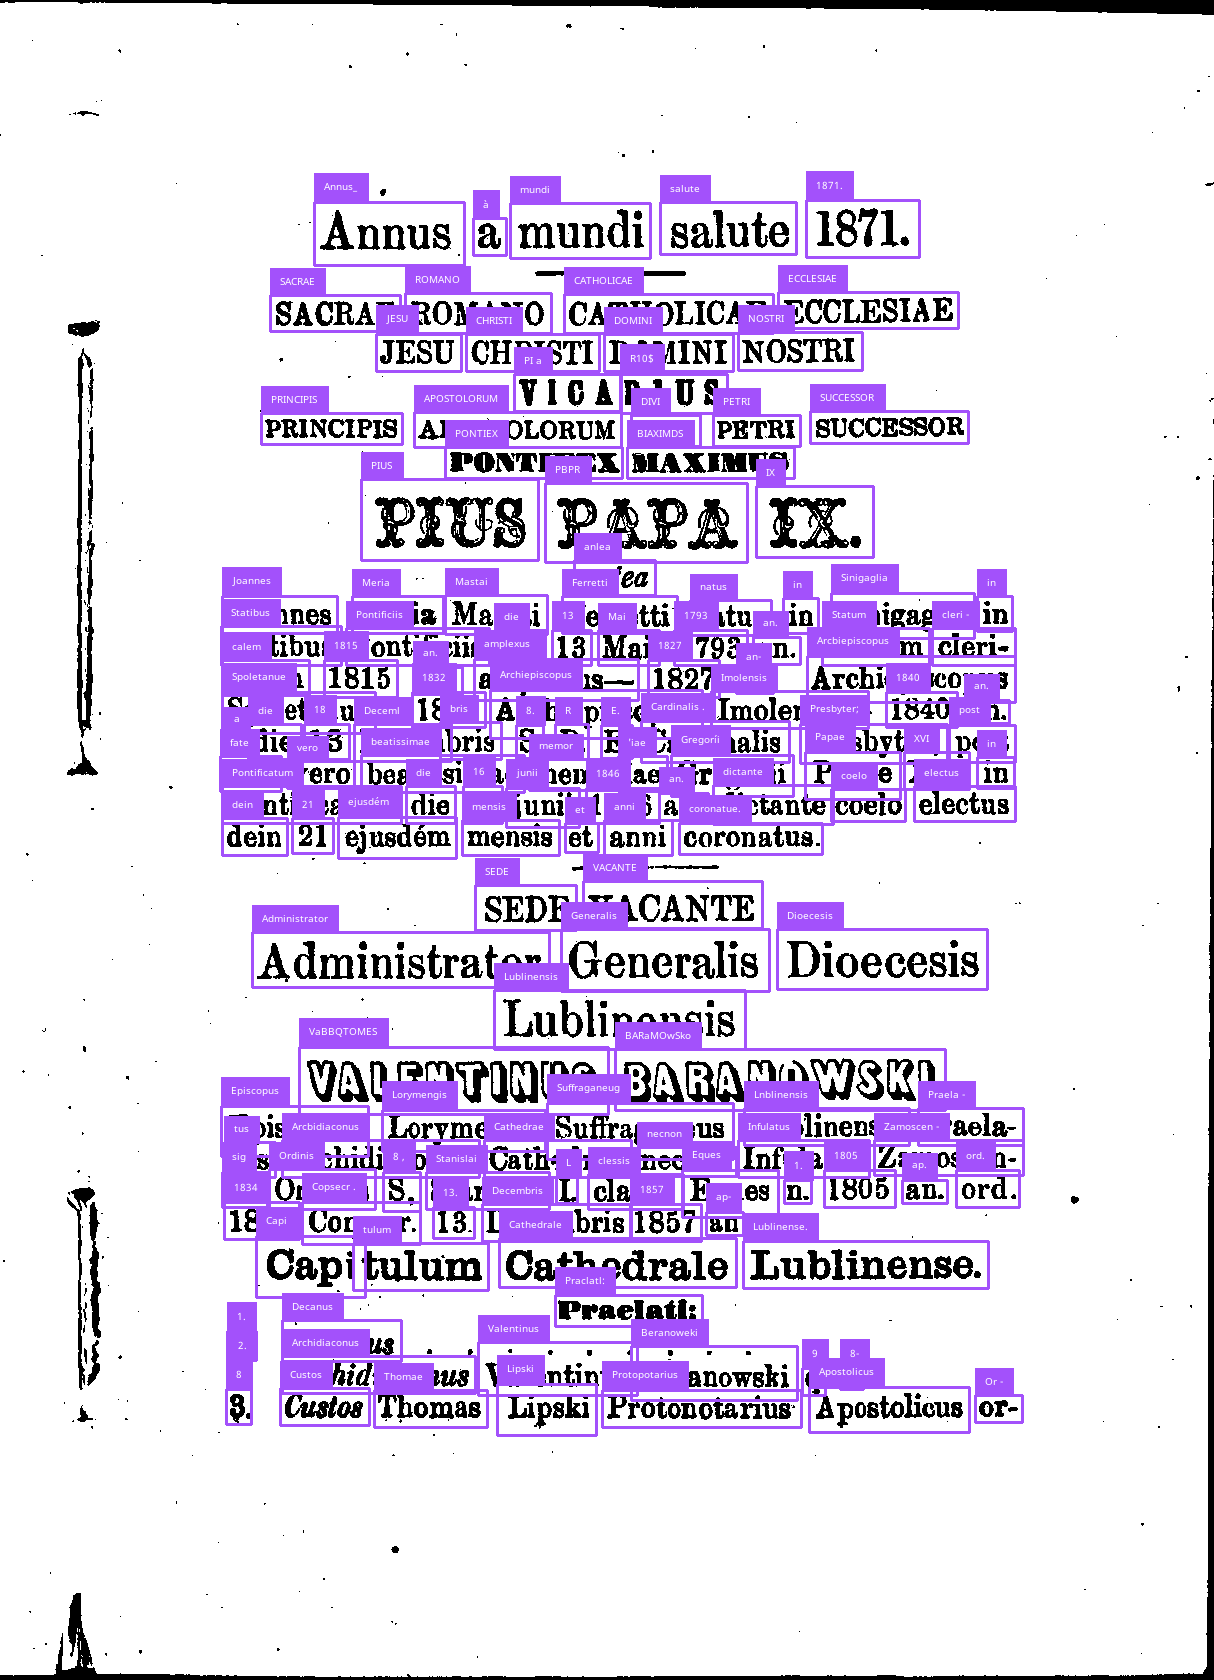

In [45]:
import easyocr
from PIL import Image, ImageDraw, ImageFont
import easyocr
import supervision as sv
import cv2
import numpy as np

import cv2
import numpy as np
BINARY_THREHOLD = 180
def preprocess_for_ocr(img: Image.Image) -> Image.Image:
    """
    Preprocess a PIL image patch for OCR.
    
    Args:
        img (PIL.Image): Input image patch
        
    Returns:
        PIL.Image: Preprocessed image patch
    """
    # Convert to numpy array
    img_np = np.array(img)
    
    # Convert to grayscale if needed
    if len(img_np.shape) == 3:
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        
    # Apply adaptive thresholding
    filtered = cv2.adaptiveThreshold(
        img_np.astype(np.uint8), 
        255, 
        cv2.ADAPTIVE_THRESH_MEAN_C, 
        cv2.THRESH_BINARY, 
        41,
        3
    )
    
    # Apply morphological operations
    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    
    # Additional thresholding for smoothing
    ret1, th1 = cv2.threshold(img_np, BINARY_THREHOLD, 255, cv2.THRESH_BINARY)
    ret2, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(th2, (1, 1), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Combine results
    or_image = cv2.bitwise_or(th3, closing)
    
    # Convert back to PIL
    return Image.fromarray(or_image)

reader = easyocr.Reader(["la"])
font = ImageFont.load_default()

with Image.open(image_path) as img:
    img = preprocess_for_ocr(img)
    image_for_drawing = img.convert("RGB").copy()
    draw = ImageDraw.Draw(image_for_drawing)

    output = reader.readtext(np.array(image_for_drawing),    
                            paragraph=False,
                            detail=1,
                            decoder='greedy',            # greedy działa najlepiej dla "liter po literze"
                            slope_ths=0.0,               # NIE łącz nawet lekko przekrzywionych znaków
                            ycenter_ths=0.0,             # NIE łącz znaków, które nie są idealnie na tej samej wysokości
                            height_ths=0.0,              # NIE łącz znaków o różnych wysokościach
                            width_ths=0.0,)

    xyxy, confidences, class_ids, label = [], [], [], []


    for detection in output:
        bbox, text, confidence = detection[0], detection[1], detection[2]
    
        # Convert bounding box format
        x_min = int(min([point[0] for point in bbox]))
        y_min = int(min([point[1] for point in bbox]))
        x_max = int(max([point[0] for point in bbox]))
        y_max = int(max([point[1] for point in bbox]))
    
        # Append data to lists
        xyxy.append([x_min, y_min, x_max, y_max])
        label.append(text)
        confidences.append(confidence)
        class_ids.append(0)  

    # Convert to NumPy arrays
    detections = sv.Detections(
        xyxy=np.array(xyxy),
        confidence=np.array(confidences),
        class_id=np.array(class_ids)
    )

    # Annotate image with bounding boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.RichLabelAnnotator(font_path="/Users/user/Projects/ecclesiasticalOCR/layoutLMv3/NotoSans-Regular.ttf")

    annotated_image = box_annotator.annotate(scene=image_for_drawing, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=label)

    # Display and save the annotated image
    #sv.plot_image(image=annotated_image)
    display(annotated_image)


In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests
from transformers import logging
logging.set_verbosity_info()
# load image from the IAM database (actually this model is meant to be used on printed text)


ocr_processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-printed')
ocr_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-small-printed')

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests

# load image from the IAM database (actually this model is meant to be used on printed text)

image = Image.open(image_path).convert("RGB")

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-printed')
pixel_values = processor(images=image, return_tensors="pt").pixel_values


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.43G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 1024,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.52.0.dev0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [49]:

generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)


In [50]:
generated_text

['HHH']

In [52]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests

# load image from the IAM database (actually this model is meant to be used on printed text)

processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-printed')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-printed')
pixel_values = processor(images=image, return_tensors="pt").pixel_values

generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 1024,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.52.0.dev0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 1024,


In [53]:
generated_text

'HHH'